In [1]:
# CBF imports
import scipy
import numpy as np
import matplotlib.patches as pat
import matplotlib.pyplot  as plt
from data      import make_rectangle, insert_shape, plot_data, plot_angle_data, get_gparams
from agent     import Agent
from controls  import hjb_controls, hjb_controls_parallel
from optim     import get_learning_cbfs_lagrangian_hj, get_h, get_h_curr, get_learning_cbfs_lagrangian_hj_optim, cvx_train_cbf, clarabel_solve_cbf, fit_cbf_w_inv, gradient_descent
from utils     import plot_cbf, plot_angles, _plot_angles, quad_plot, union, intersection, difference

# HJB imports 
import jax
import jax.numpy            as jnp
import matplotlib.animation as anim
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import hj_reachability      as hj
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

spacing: 0.14677419354838708
X_0 GRID INFORMATION
 domain: [ -2.275 , 2.275 ]
 n: 32 
 density: 0.1421875
X_1 GRID INFORMATION
 domain: [ -2.275 , 2.275 ]
 n: 32 
 density: 0.1421875
X_2 GRID INFORMATION
 domain: [ 0 , 6.283185307179586 ]
 n: 20 
 density: 0.3141592653589793


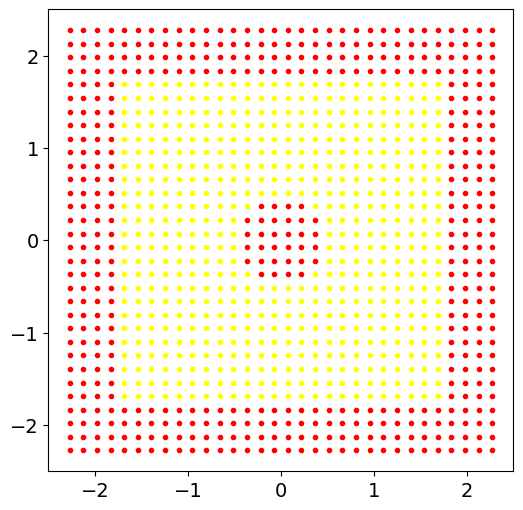

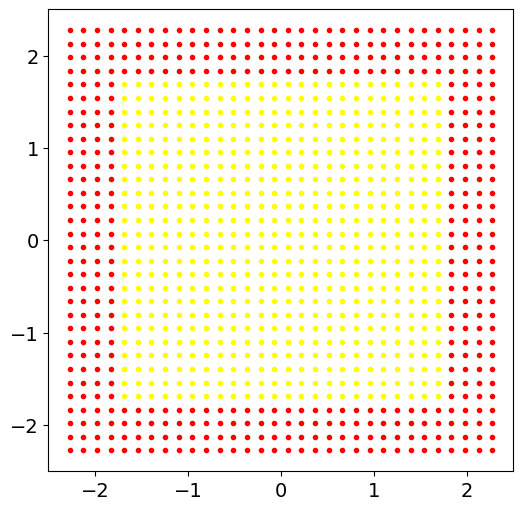

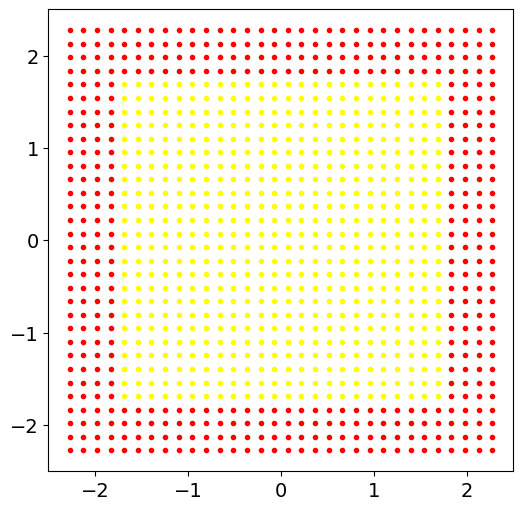

In [2]:
#########################
### Data Construction ###
#########################

width         = 3.5
density       = 50
unsafe_margin = 0.3
thn           = 20

# make grid and obstacles
obs_funcs = []
grid, params, obs_dict, is_obs_grid = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
#obs_dict = insert_shape(np.array([0,  1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)
obs_dict, is_obs_circ = insert_shape(np.array([0, 0]), grid, obs_dict, shape='circle', scale=0.50, theta=0)
obstacles = np.array([pt for pt in grid if obs_dict[tuple(np.round(pt, 3))] != 0])
obs_funcs.append(is_obs_grid)
obs_funcs.append(is_obs_circ)

#### DEBUG: USE TO VALIDATE CHECK_OBS ###
'''
from data import check_obs
for pt in grid:
    if check_obs(pt, obs_funcs):
        plt.plot(pt[0], pt[1], marker='.', color="r", linestyle="none")
    else:
        plt.plot(pt[0], pt[1], marker='.', color="yellow", linestyle="none")
plt.show()
'''

# grids for centers and unsafe samples
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))


# initialize hjb grid
lo, hi, n, spacing = params
print("spacing:", spacing)
lo = lo + (0       ,)
hi = hi + (2*jnp.pi,)
n  = n  + (thn     ,)

for i in range(len(lo)):
    print("X_" + str(i) + " GRID INFORMATION\n", 
          "domain: [", lo[i], ",", hi[i], "]\n", 
          "n:", n[i],"\n", 
          "density:", (hi[i]-lo[i])/n[i])


hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n, periodic_dims=2)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(1024, 2)
(32, 32, 20)


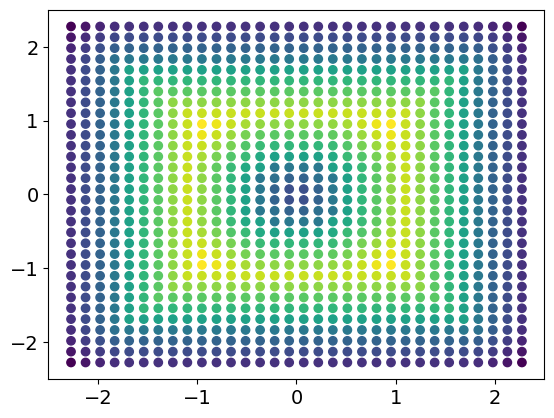

In [3]:
#####################################
### Make Signed Distance Function ###
#####################################

l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        for k in range(n[2]):
            if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j, k, :-1]), 3))] != 0:
                l[i, j, k] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j, k, :2], axis=1))
            else:
                l[i, j, k] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j, k, :2], axis=1))

print(grid.shape)
print(l.shape)
plt.scatter(grid[:,0], grid[:,1], c=l[...,0].reshape(-1, 1))
plt.show()

In [4]:
############################
### Configure HJB Solver ###
############################

gamma  = 0.20
cbvf   = True
umax   = 0.40
utype  ="box"
V      = 0.10
l      = jnp.array(l)
values = l 
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
####################################
### Solver PDE for final surface ###
####################################

dynamics = hj.systems.Bicycle(gamma=gamma, V=V, umax=umax)
time = 0.
target_time = -500
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|##############################| 500.0000/500.0 [00:02<00:00, 192.07sim_s/s]


<Figure size 640x480 with 0 Axes>

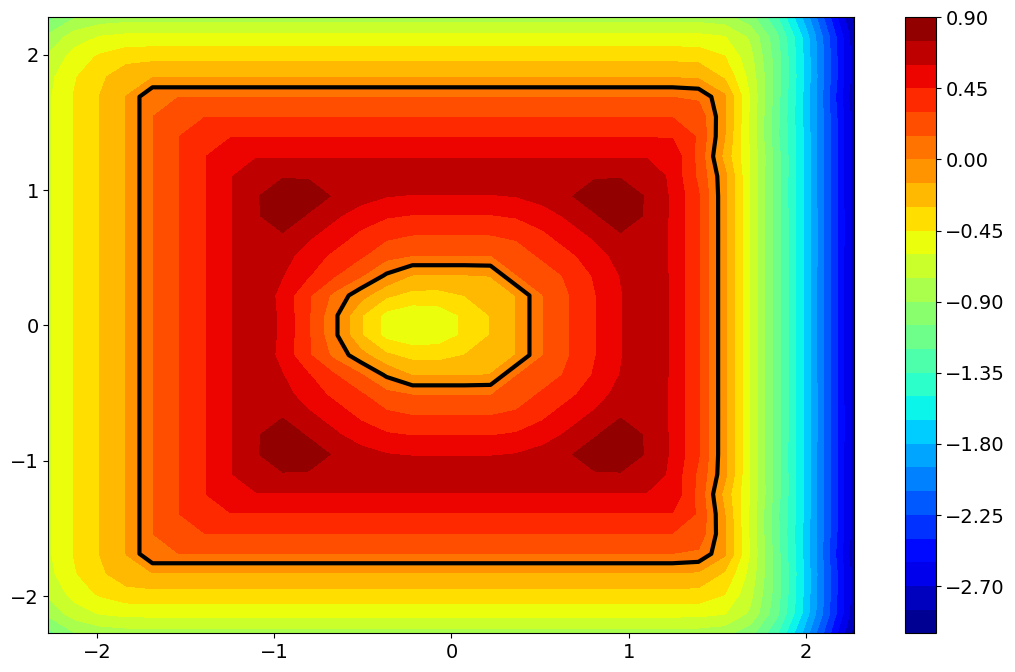

In [6]:
##########################
### Plot final surface ###
##########################

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :, 0].T, levels=30)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :, 0].T,
            levels=0,
            colors="black",
            linewidths=3)

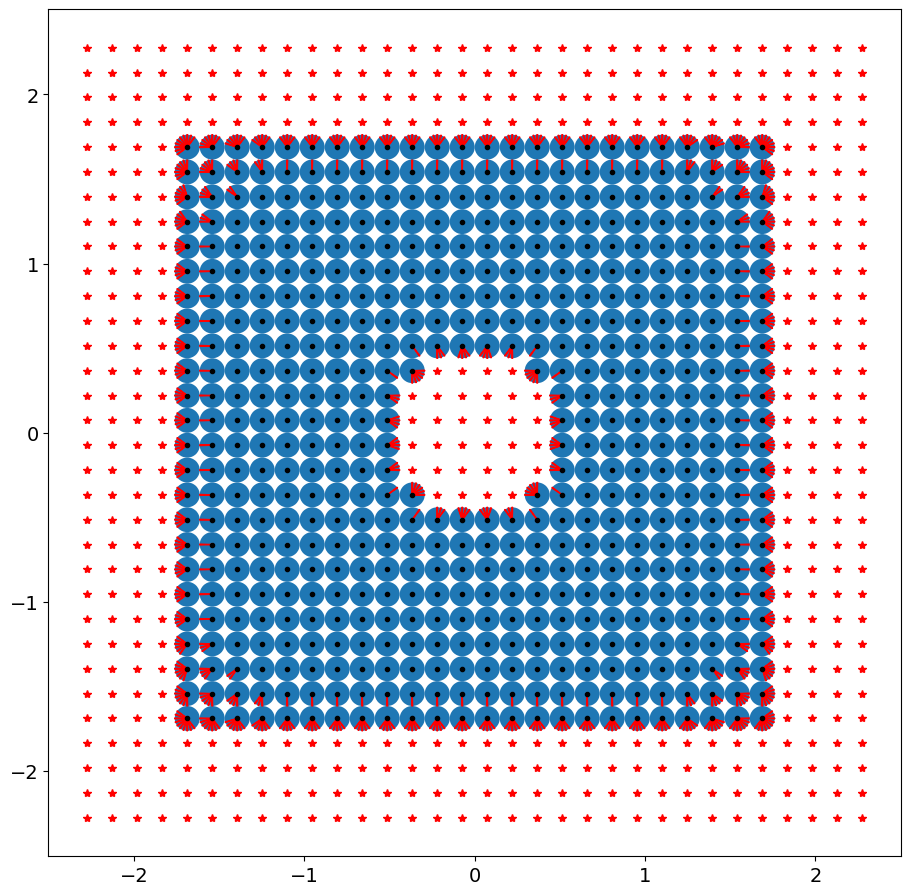

In [7]:
#######################################
### Plot V at each x,y using arrows ###
#######################################
ddegrees = 2

fig, ax = plt.subplots(figsize=(11,11))

plt.rc('xtick', labelsize=14)                                                
plt.rc('ytick', labelsize=14)                                                

for x in grid:                                                               
    if obs_dict[tuple(np.round(x, 3))] == 0:                               
        ax.plot(x[0], x[1], color="black", marker=".", linestyle="none")   
        A = pat.Annulus(x, spacing/2, spacing/2-0.01)
        ax.add_patch(A)
        pt = np.array([x[0], x[1], 0])
        idx = hjb_grid.nearest_index(pt)[:2]
        for i, Vtheta in enumerate(target_values[idx[0], idx[1]]):
            theta = hjb_grid.states[idx[0], idx[1], i][-1]
            if Vtheta <= 0:
                B = pat.Wedge(x, spacing/2, 360/(2*np.pi)*theta - ddegrees, 360/(2*np.pi)*theta + ddegrees, width=spacing/2, color='r')  
                ax.add_patch(B)
            #else:
            #    B = pat.Wedge(  x, s/2, 360/(2*np.pi)*theta - 1, 360/(2*np.pi)*theta + 1, width=s/2, color='b')  
            #    ax.add_patch(B)
    else:
        ax.plot(x[0], x[1], color="red"   , marker="*", linestyle="none") 

plt.show()

In [8]:
##############################
### Plot V(x, y, theta(t)) ###
##############################

vmin, vmax = target_values.min(), target_values.max()
levels = np.linspace(round(vmin), round(vmax), 5*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 target_values[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, target_values.shape[-1], interval=50).to_html5_video())
plt.close(); animation

In [9]:
##########################################
### Solve for backwards reachable tube ###
##########################################

times = np.linspace(0, -500, 100)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|##############################| 500.0000/500.0 [00:02<00:00, 179.11sim_s/s]


In [10]:
##########################################
### Visualize backwards reachable tube ###
##########################################

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :, 10].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, 10].T,
                levels=0,
                colors="black",
                linewidths=3)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [11]:
###########################
### Agent Configuration ###
###########################

bf    = 31    # csrbf order
b     = 0.0#-0.5   # offset (-0.5)
s     = 1.00  #0.75# csrbf zeroing
nm    = 0.20  # nm * n_safe = number of neighbors to consider
pct   = 0.00  # num neighber percentile under which boundary
mult  = 2
utype = utype # defined w/ hjb above
umax  = umax  # defined w/ hjb above
gamma = gamma # defined w/ hjb above
solver        ='CLARABEL'
sensor_radius = 1.1
rx            = sensor_radius + 0.2 # sample radius
rc            = sensor_radius # radius around scan in which centers are chosen
init_x        =-1.1
init_y        =-1.1
init_theta    = 0

a = Agent(dynamics, np.array([init_x, init_y, init_theta]), grid, obs_dict, width         = width, 
                                                                            sensor_radius = sensor_radius,
                                                                            bf            = bf, 
                                                                            b             = b, 
                                                                            s             = s,
                                                                            utype         = utype,
                                                                            umax          = umax,
                                                                            gamma         = gamma,
                                                                            solver        = solver,
                                                                            spacing       = spacing,
                                                                            obstacles     = obstacles)

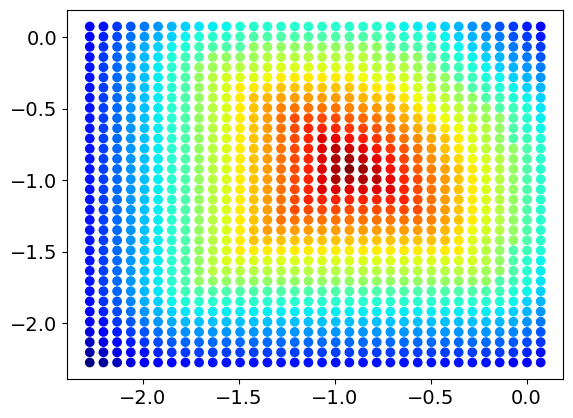

100%|##############################| 500.0000/500.0 [00:03<00:00, 136.02sim_s/s]


<Figure size 640x480 with 0 Axes>

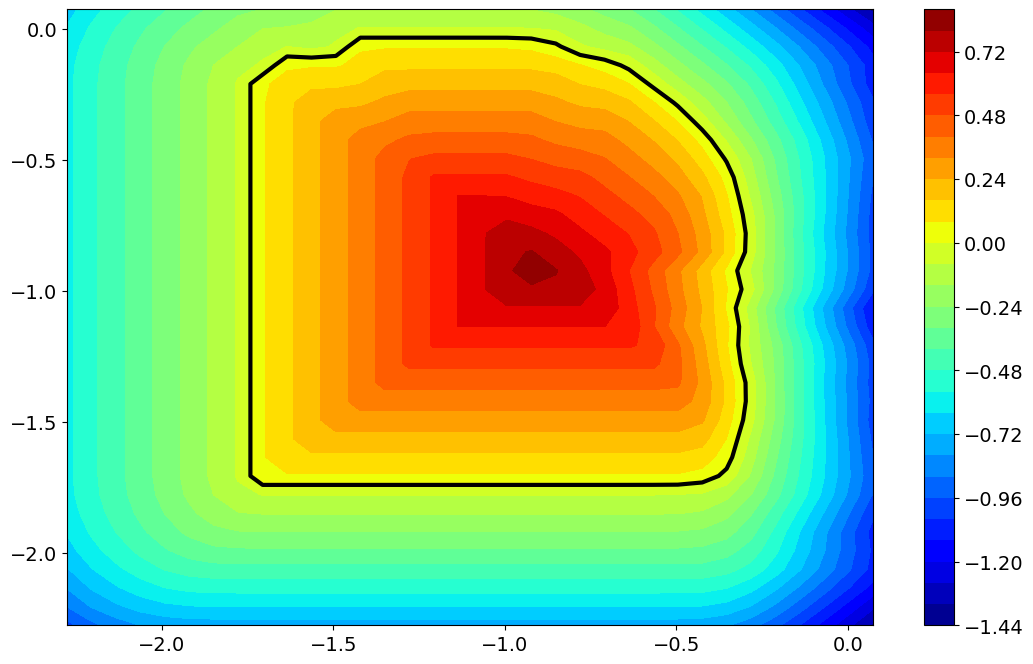

In [12]:
####################
### Initial scan ###
####################

# scan states 
pts_safe, pts_unsafe,\
             in_scan_f = a.scan(ret_in_scan_f=True) 
scan_funcs = [in_scan_f]
samples, gparams,\
is_obs_sample, x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
sample_funcs = [is_obs_sample]
loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)

In [13]:
vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
levels = np.linspace(vmin, vmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(loc_hjb_grid.coordinate_vectors[0],
                 loc_hjb_grid.coordinate_vectors[1],
                 loc_V[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(loc_hjb_grid.coordinate_vectors[0],
                loc_hjb_grid.coordinate_vectors[1],
                loc_V[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, loc_V.shape[-1], interval=50).to_html5_video())
plt.close()
animation

In [14]:
scan_safe, scan_unsafe,\
x2pi_scan, x0_scan = a.scan_hjb(loc_V, loc_hjb_grid, bicycle=True, boundary_condition=True)
n_safe             = len(scan_safe) #len(pts_safe)
x_buffer, x_safe   = a.make_buffer(scan_safe, int(nm * n_safe), pct, bicycle=True)

x2pi = np.vstack((x2pi_samp, x2pi_scan))
x0   = np.vstack((x0_samp, x0_scan))

# unsafe states 
if scan_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((scan_unsafe, samples))
else: 
    x_unsafe = samples    

counts [251 247 249 ... 313 293 271]
pct 0.0


In [15]:
#######################
### Collect centers ###
#######################

C = []
for x in c_grid:
    if np.linalg.norm(x[:2] - a.pos[:2]) <= rc:
        C.append(x)
C = np.array(C)

tmp = []
for p in C:
    c = np.repeat(p.reshape(1, -1), hjb_grid.states.shape[2], axis=0)
    c = np.hstack((c, np.array(hjb_grid.coordinate_vectors[2]).reshape(-1, 1)))
    cend = np.array([p[0], p[1], 2*np.pi]).astype(np.float32)
    tmp.append(np.vstack((c,cend)))
C = np.vstack(tmp) 

a.centers.append(C)

dx = params[-1]
dth = abs(loc_hjb_grid.states[0,0,0,2]-hjb_grid.states[0,0,1,2])
print("ratio of subsequent theta gridpt dist to csrbf zeroing dist:\n",s/dth)
print("ratio of subsequent x gridpt dist to csrbf zeroing dist:\n",s/dx)
for i in range(2):
    print("X_" + str(i) + " GRID INFORMATION\n", 
          "domain: [", loc_hjb_grid.domain.lo[i], ",", loc_hjb_grid.domain.hi[i], "]\n", 
          "n:", (loc_hjb_grid.domain.hi[i] - loc_hjb_grid.domain.lo[i]) / spacing,"\n", 
          "density:", hjb_grid.states.shape[i]/(hjb_grid.domain.hi[i]-hjb_grid.domain.lo[i]))
print("X_" + str(2) + " GRID INFORMATION\n", 
      "domain: [", hjb_grid.domain.lo[2], ",", hjb_grid.domain.hi[2], "]\n", 
      "n:", (hjb_grid.domain.hi[2] - hjb_grid.domain.lo[2]) / spacing,"\n", 
      "density:", hjb_grid.states.shape[2]/(hjb_grid.domain.hi[2]-hjb_grid.domain.lo[2]))

sth = s/dx * dth
print("theta zeroing dist should be:", sth)
print("ratio of subsequent theta gridpt dist to modified csrbf zeroing dist:\n",sth/dth)
theta_scale = (n[2] * (hi[0] - lo[0])) / (n[0] * 2*np.pi)
print(theta_scale)
#a.theta_scale = theta_scale #/ 4
print(a.theta_scale)
#1 / 2*np.pi 

#from optim import get_phiT
#phi = get_phiT(a)
#phi(np.array([0, 0, 0]), C)

ratio of subsequent theta gridpt dist to csrbf zeroing dist:
 3.1830988
ratio of subsequent x gridpt dist to csrbf zeroing dist:
 6.813186813186814
X_0 GRID INFORMATION
 domain: [ -2.275 , 0.073387094 ]
 n: 16.000002 
 density: 7.032967032967033
X_1 GRID INFORMATION
 domain: [ -2.275 , 0.073387094 ]
 n: 16.000002 
 density: 7.032967032967033
X_2 GRID INFORMATION
 domain: [ 0 , 6.283185307179586 ]
 n: 42.808515279685096 
 density: 3.183098861837907
theta zeroing dist should be: 2.1404257
ratio of subsequent theta gridpt dist to modified csrbf zeroing dist:
 6.813186
0.4525968694175774
None


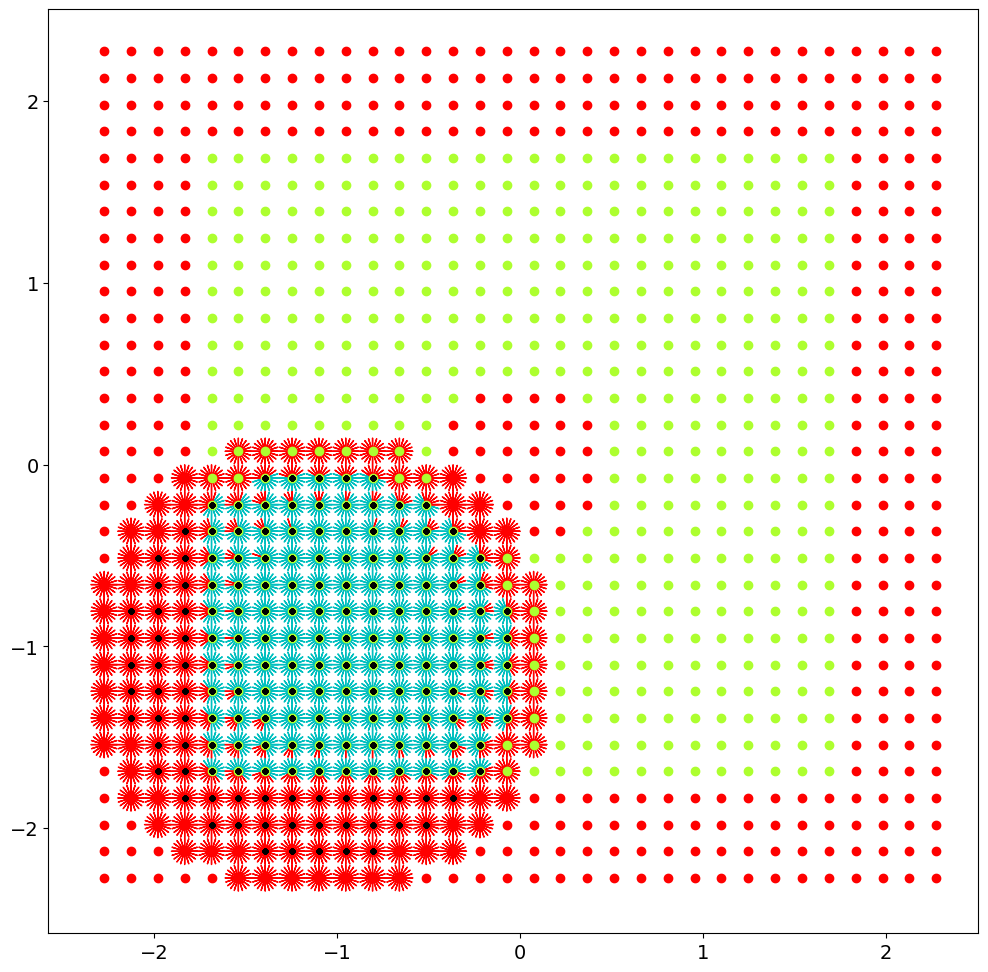

In [16]:
#############################
### Plot Initial CBF data ###
#############################

plot_angle_data(C, grid, obs_dict, spacing, safe=x_safe, buffer=x_buffer, unsafe=scan_unsafe, samples=samples)

In [17]:
###########################################
### Obtain controls from Value Function ###
###########################################

from tqdm import tqdm

u_safe = hjb_controls_parallel(a, x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    u_buffer = hjb_controls_parallel(a, x_buffer, loc_hjb_grid, loc_V)
else:
    u_buffer = np.array([]) 

'''
u_buffer = []
for x in tqdm(x_buffer):
    u_buffer.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
u_buffer = np.array(u_buffer)

u_safe = []
for x in tqdm(x_safe):
    u_safe.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
u_safe = np.array(u_safe)
'''

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 30 08:08:21 AM: Your problem has 2295 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 30 08:08:21 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 30 08:08:21 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 30 08:08:21 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 30 08:08:21 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 30 08:08:21 AM: Compiling problem (target solver=CLARABEL)

'\nu_buffer = []\nfor x in tqdm(x_buffer):\n    u_buffer.append(hjb_controls(a, x, loc_hjb_grid, loc_V))\nu_buffer = np.array(u_buffer)\n\nu_safe = []\nfor x in tqdm(x_safe):\n    u_safe.append(hjb_controls(a, x, loc_hjb_grid, loc_V))\nu_safe = np.array(u_safe)\n'

In [18]:
##############################
### Initial CBF Parameters ###
##############################
    
gamma_safe   = 0.00
gamma_unsafe = 0.00
gamma_dyn    = 0.00
lam_safe     = 1
lam_dyn      = 1
lam_unsafe   = 1
lam_dh       = 0
lam_sp       = 0

In [19]:

print(loc_hjb_grid.states.shape)
print(loc_V.shape)
print(loc_hjb_grid.interpolate(loc_V, C[0]))




(34, 34, 20, 3)
(34, 34, 20)
-0.42253166


In [52]:
#########################
### Solve Initial CBF ###
#########################

# get h as a function of agent parameter
h = get_h(a)

#print(x2pi)
#print(x0)
#L = get_learning_cbfs_lagrangian_hj_optim(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh, gamma_safe, gamma_dyn, gamma_unsafe)
#theta, _, _ = scipy.optimize.fmin_l_bfgs_b(L, np.random.rand(C.shape[0], 1), approx_grad=False, iprint=50)
#theta = cvx_train_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, lam_dh=lam_dh, lam_sp=lam_sp, verbose=True)
#theta = np.array(clarabel_solve_cbf(a, x_safe.astype(np.float64), u_safe.astype(np.float64), x_buffer.astype(np.float64), 
#                                       u_buffer.astype(np.float64), x_unsafe.astype(np.float64), gamma_safe, gamma_dyn, gamma_unsafe))#,
#                                       x2pi=x2pi.astype(np.float64), x0=x0.astype(np.float64) ))
# prepare data 
#theta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))
#C = loc_hjb_grid.states.reshape(-1, 3)
interpv = jax.vmap(loc_hjb_grid.interpolate, in_axes=(None, 0))
b = interpv(loc_V, C)
theta = fit_cbf_w_inv(a, C, b)
it = 100; eps=1e-3; tol=1e-4; 
theta = gradient_descent(a, theta, it, eps, tol, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh)
a.thetas.append(theta)
a.rectify_c_and_theta()

# initialize plotting objects
init_pos       = np.copy(a.pos)
curr_centers   = np.copy(np.array(a.centers))
curr_thetas    = np.copy(np.array(a.thetas))
curr_data      = np.copy(np.vstack((x_safe, x_buffer, x_unsafe)))
curr_traj      = np.copy(a.pos.reshape(-1, 3))
quad_plot_args =[(0, curr_centers, curr_thetas, curr_data)]
data_safe = np.vstack((x_buffer, x_safe))
data_unsafe = x_unsafe
all_C = C

safe L shape: (2295,)
safe dynamics L shape: (2295,)
unsafe L shape: (2766,)
safe grad norm L shape: (2295,)
D_safe_L shape: (2295, 3717)
D_safe_dyn_L shape: (2295, 3717)
D_unsafe_L shape: (2766, 3717)
Dgnorm_safe_L shape (2295, 3717)
safe L shape: (2295,)
safe dynamics L shape: (2295,)
unsafe L shape: (2766,)
safe grad norm L shape: (2295,)
D_safe_L shape: (2295, 3717)
D_safe_dyn_L shape: (2295, 3717)
D_unsafe_L shape: (2766, 3717)
Dgnorm_safe_L shape (2295, 3717)
it 0 loss: 490553.97
safe L shape: (2295,)
safe dynamics L shape: (2295,)
unsafe L shape: (2766,)
safe grad norm L shape: (2295,)
D_safe_L shape: (2295, 3717)
D_safe_dyn_L shape: (2295, 3717)
D_unsafe_L shape: (2766, 3717)
Dgnorm_safe_L shape (2295, 3717)
it 1 loss: 490557.9
centers shape before:
(3717, 3)
numc 3717
cmax before 3717
numc <= self.cmax
Cnew shape before (3717, 3)
Cnew shape after (3717, 3)
theta shape before (3717,)
theta_shape after (3717,)
cmax after 3717
centers shape after
(3717, 3)


In [35]:
print(theta.shape)

(3717,)


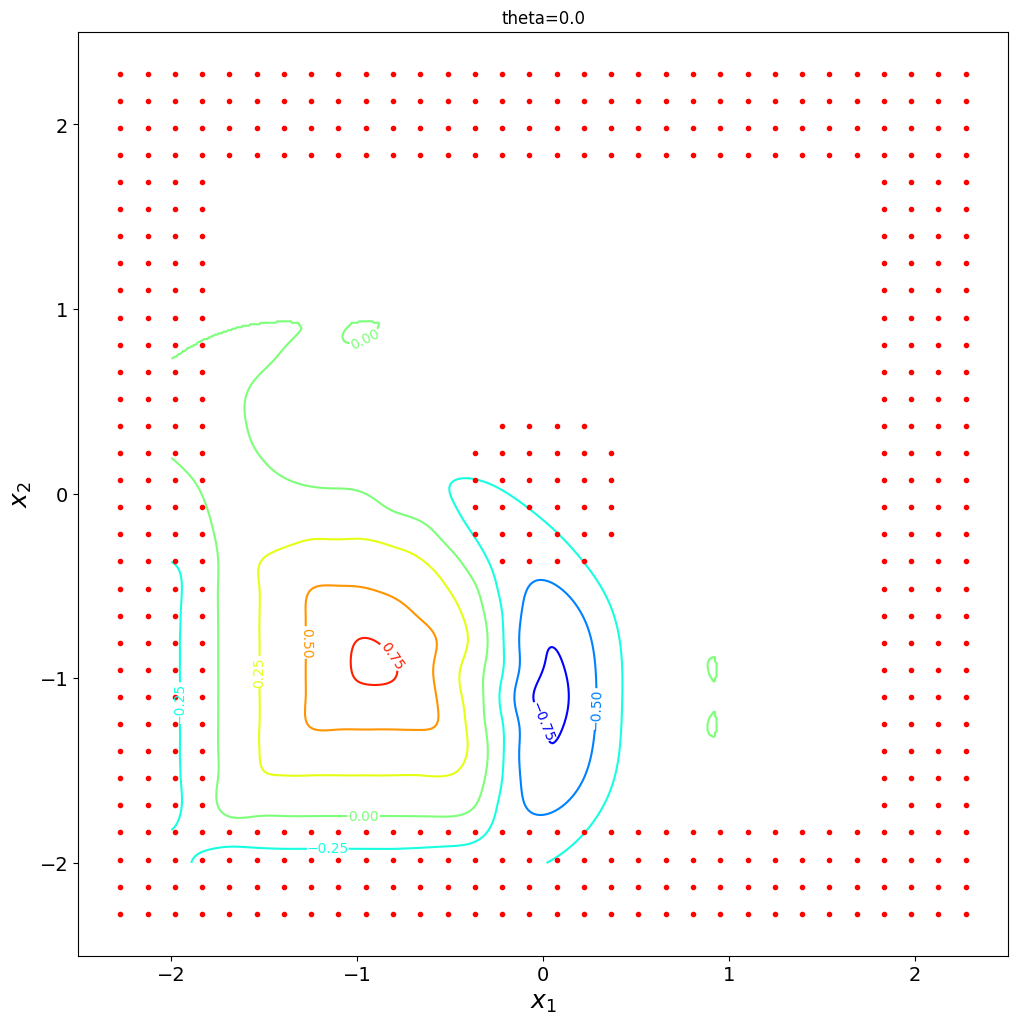

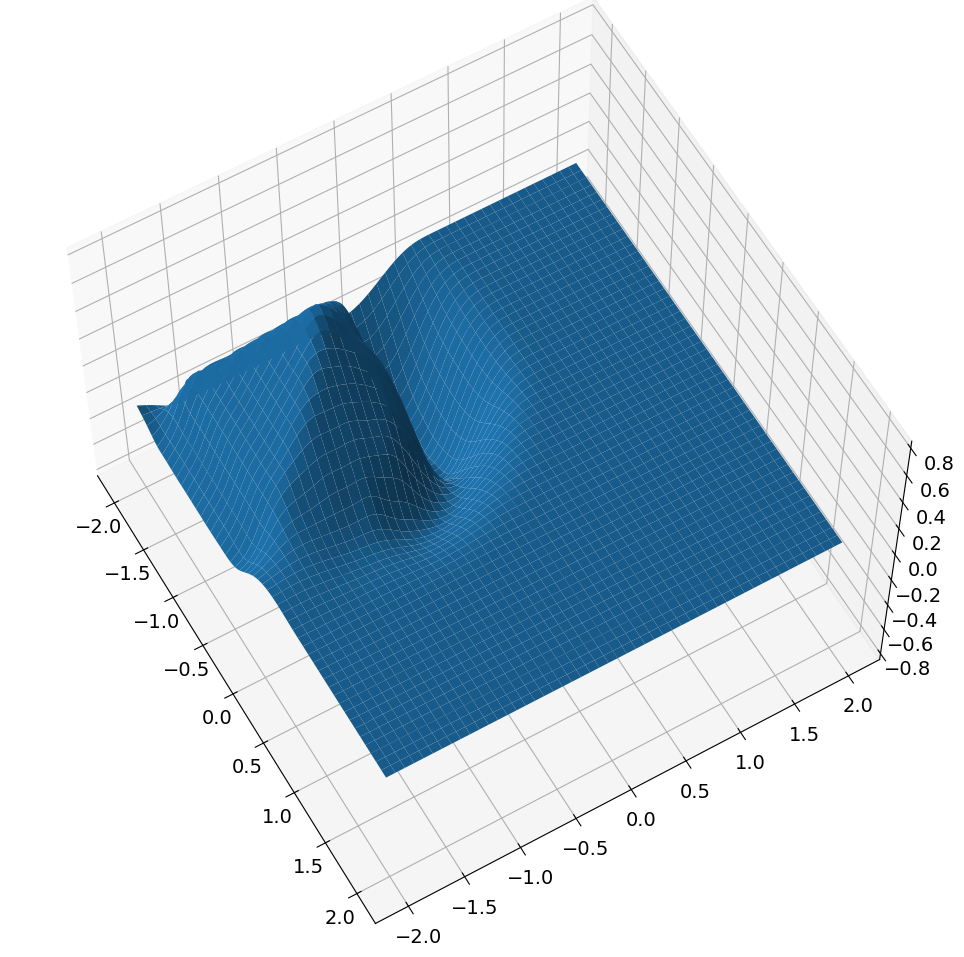

max h 0.8161084633121871


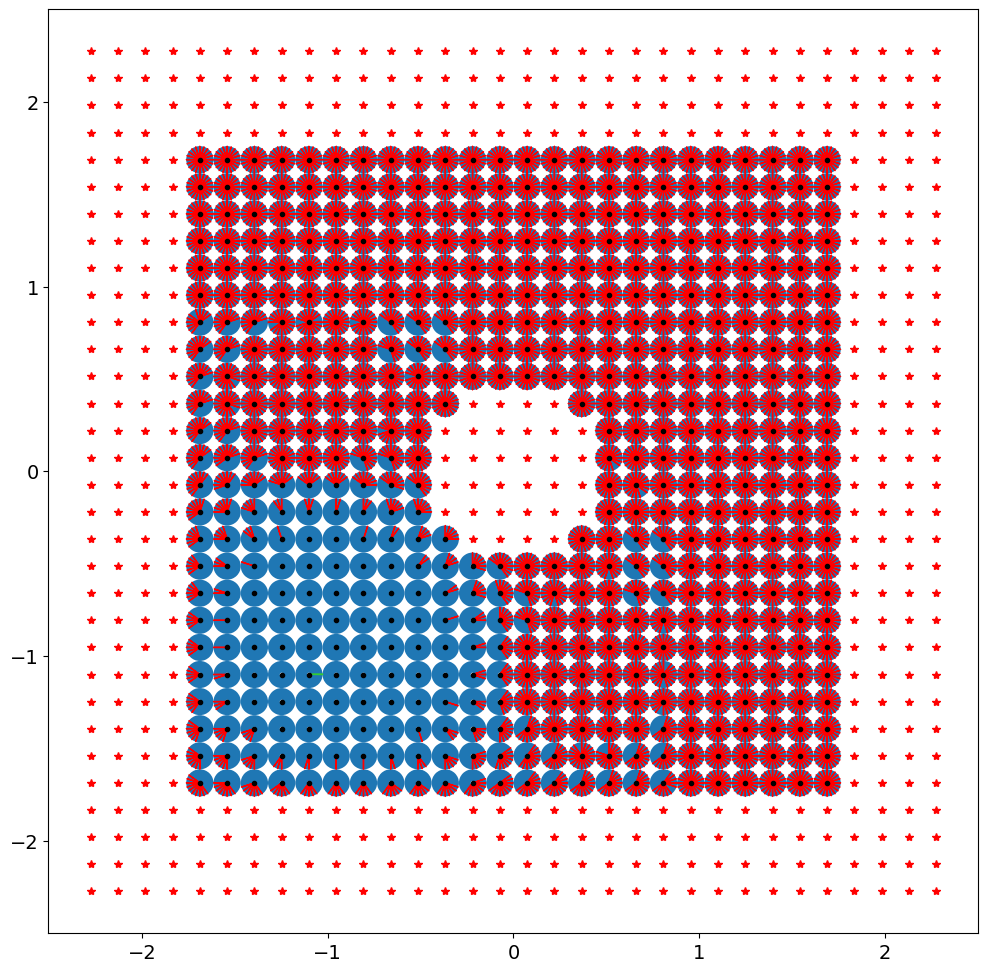

In [36]:
########################
### Plot Initial CBF ###
########################

h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1], obstacles=obstacles)
#h_max = plot_cbf(a, loc_hjb_grid.states.reshape(-1, 3)[np.newaxis,:], theta[np.newaxis, :], angle=a.pos[-1], obstacles=obstacles)
#h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=2*np.pi, obstacles=obstacles)
plot_angles(a, grid, loc_hjb_grid, obs_dict, pos=a.pos)

In [79]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.005   # numerical integration timestep
tol  = 0.005   # h-value at which to halt approach
eps  = 0.001
dx   = 0.5     # if |x'-x|<dx, approach again
tend = 20      # Duration of boundary approach
T    = 0.3     # MPC horizon (default timestep is 0.05)
N    = 3       # number of CBFs to learn

target: [ 1 -1  0]
position is [-1.1 -1.1  0. ]
start time is 0


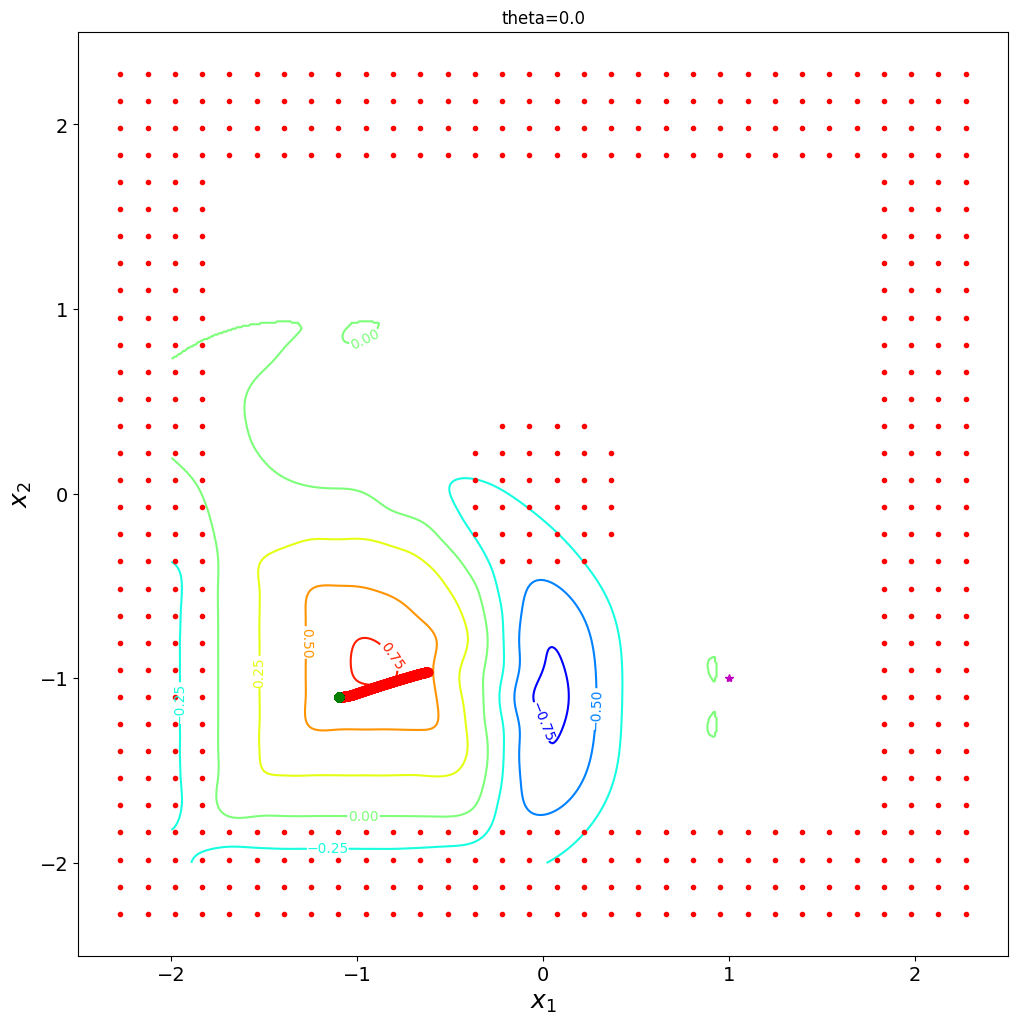

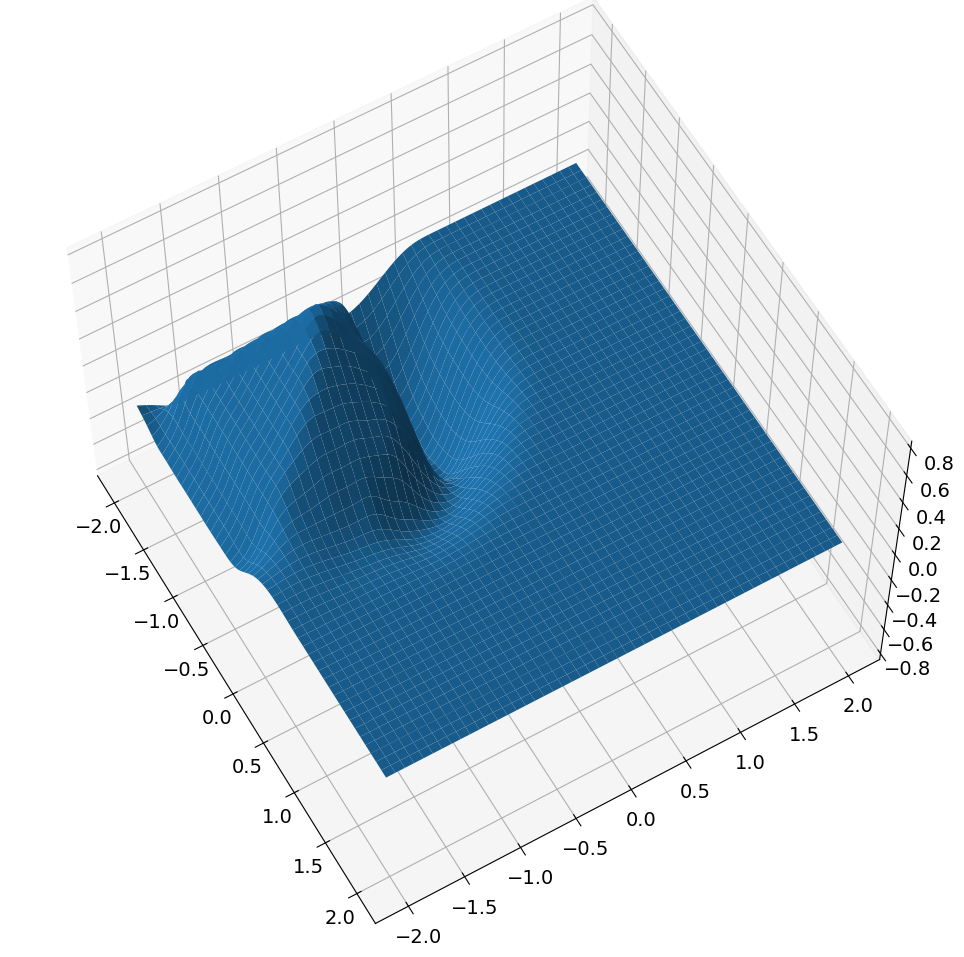

max h 0.8161084633121871
new position is [-0.62029278 -0.96499896  0.16801012]
h is now 0.568703283792411
new time is 20
dx: 0.5259008403385904


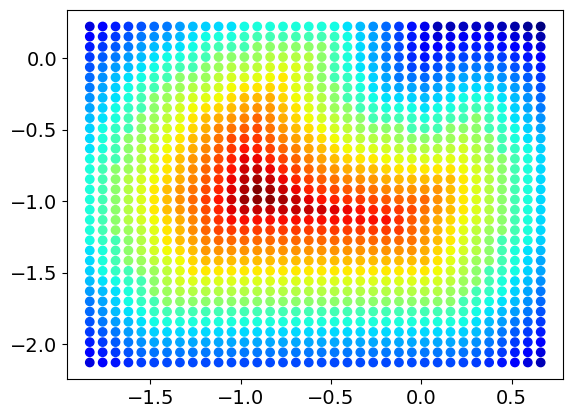

100%|############################################################################################################################################| 500.0000/500.0 [00:04<00:00, 116.84sim_s/s]


n safe 2597
scan safe shape (2597, 3)
counts [386 388 375 ... 283 268 260]
pct 0.0


<Figure size 640x480 with 0 Axes>

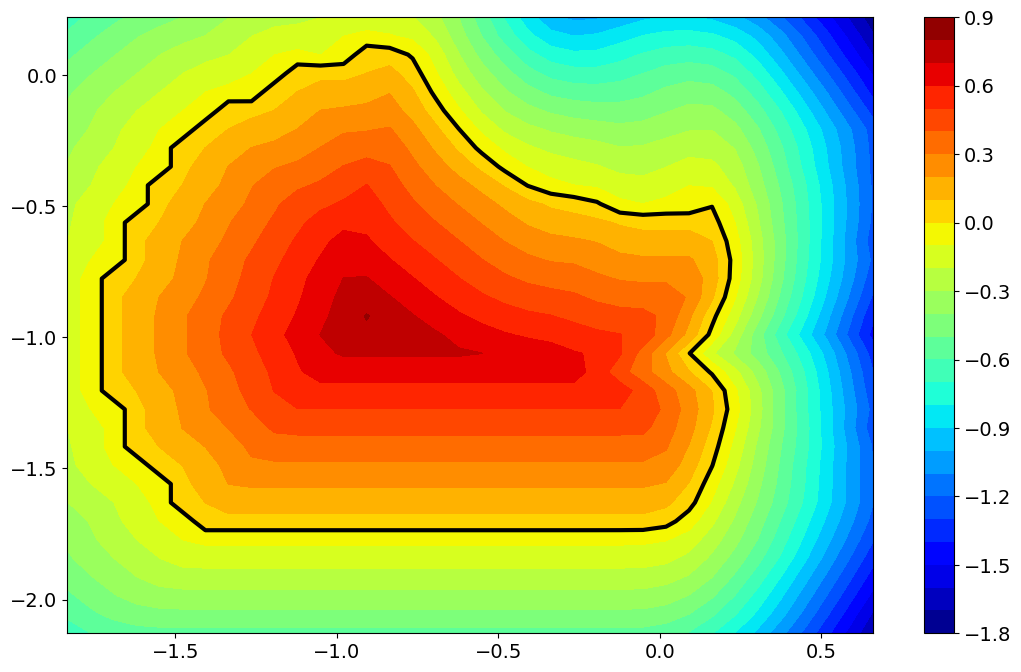

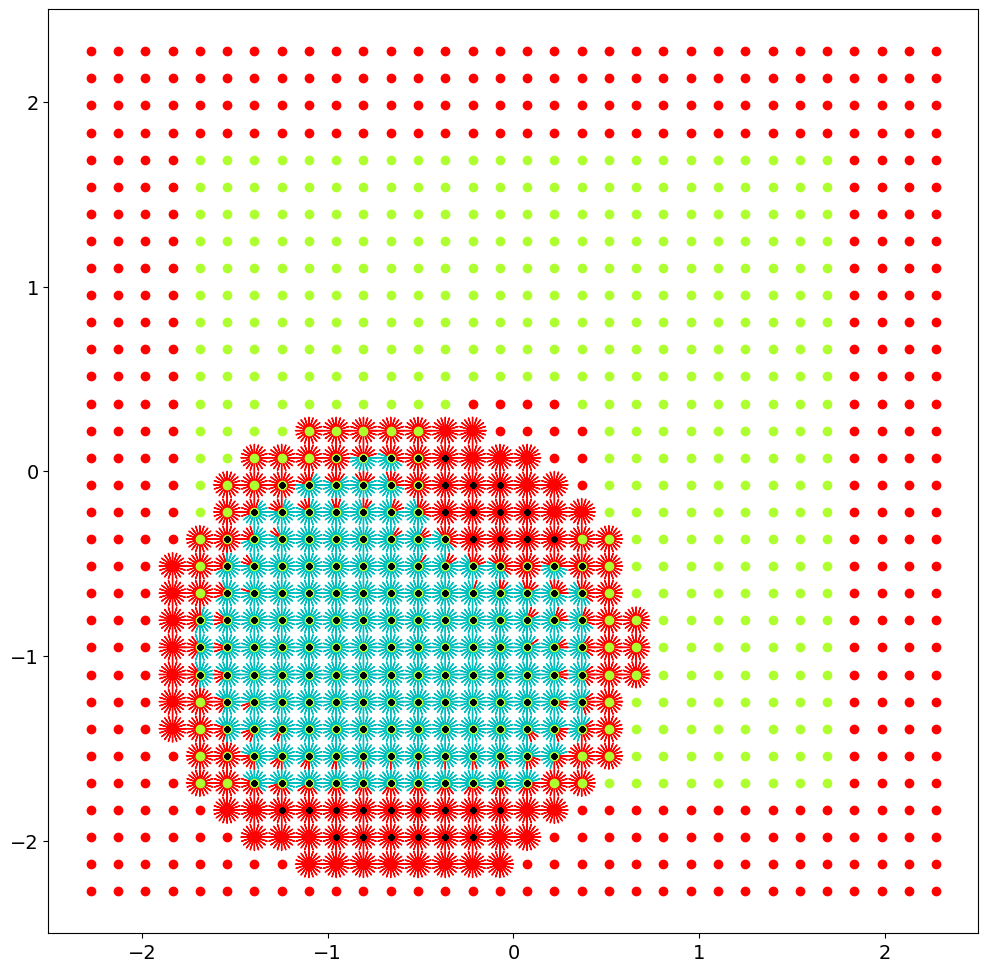

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 29 11:54:27 AM: Your problem has 2597 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 29 11:54:27 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 29 11:54:27 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 29 11:54:27 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 29 11:54:27 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 29 11:54:27 AM: Compiling problem (target solver=CLARABEL)

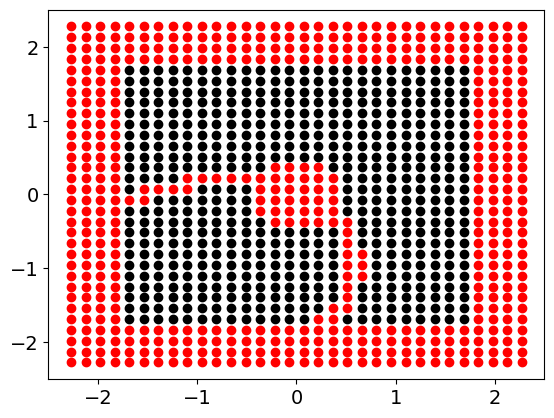

b shape (7763,)


KeyboardInterrupt: 

In [81]:
########################
### Safe Exploration ###
########################

targets   = [np.array([1, -1,       0]),
             np.array([1, -1,       0]),
             np.array([1,  1, np.pi/2]),
             np.array([1,  1, np.pi/2])]
#targets   = None

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    
    prev_pos = a.pos  
    if targets is not None:
        print("target:", targets[i]) 
        traj,usig = a.goto(targets[i], T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps)  
        print("dx:", np.linalg.norm(a.pos - prev_pos))
    else: 
        while np.linalg.norm(a.pos - prev_pos) <= dx:    
            target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
            target_angle = np.array([2 * np.pi * np.random.rand()])
            target       = np.hstack((target_pos, target_angle)) 
            while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
                target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
                target_angle = np.array([2 * np.pi * np.random.rand()])
                target       =  np.hstack((target_pos, target_angle)) 
            print("target:", target) 
            traj,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps) 
            print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################

    # scan states 
    pts_safe, pts_unsafe, in_scan_f = a.scan(ret_in_scan_f=True)
    scan_funcs.append(in_scan_f)
    samples, gparams, is_obs_sample,\
    x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
    sample_funcs.append(is_obs_sample)
    loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)
    scan_safe, scan_unsafe,\
    x2pi_scan, x0_scan = a.scan_hjb(loc_V, loc_hjb_grid, bicycle=True, boundary_condition=True)
    n_safe             = len(scan_safe) #len(pts_safe)
    print("n safe", n_safe)
    print("scan safe shape", scan_safe.shape)
    x_buffer, x_safe   = a.make_buffer(scan_safe, int(nm * n_safe), pct, bicycle=True)

    x2pi = np.vstack((x2pi_samp, x2pi_scan))
    x0   = np.vstack((x0_samp, x0_scan))
    
    # unsafe states 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples    
        
    # centers
    C = []
    for x in c_grid:
        if np.linalg.norm(x[:2] - a.pos[:2]) <= rc:
            C.append(x)
    C = np.array(C)    
    tmp = []
    for p in C:
        c = np.repeat(p.reshape(1, -1), hjb_grid.states.shape[2], axis=0)
        c = np.hstack((c, np.array(hjb_grid.coordinate_vectors[2]).reshape(-1, 1)))
        cend = np.array([p[0], p[1], 2*np.pi]).astype(np.float32)
        tmp.append(np.vstack((c, cend)))
    C = np.vstack(tmp)  
    a.centers.append(C)

    # plot CBF data
    plot_angle_data(C, grid, obs_dict, spacing, safe=x_safe, buffer=x_buffer, unsafe=scan_unsafe, samples=samples)

    # safe and buffer control
    u_safe = hjb_controls_parallel(a, x_safe, loc_hjb_grid, loc_V, verbose=True)
    if x_buffer.shape[0] != 0:
        u_buffer = hjb_controls_parallel(a, x_buffer, loc_hjb_grid, loc_V)
    else:
        u_buffer = np.array([])

    # total data 
    from data import check_obs
    all_obs_func = lambda x: check_obs(x, obs_funcs) or (check_obs(x, sample_funcs) and not check_obs(x, scan_funcs))
    out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
    obsamp_f     = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
    for x in grid:
        if obsamp_f(x):
            plt.plot(x[0], x[1], color='red', marker='o', linestyle='none')           
        else:
            plt.plot(x[0], x[1], color='black', marker='o', linestyle='none')
    plt.show()

    
    #####################
    ### Learn new CBF ###
    ##################### 
    
    theta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))#, x2pi=x2pi, x0=x0))
    a.thetas.append(theta)
    a.rectify_c_and_theta()

    # plot new CBF
    h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1], obstacles=obstacles)
    plot_angles(a, grid, hjb_grid, obs_dict)

    # collect quad plot data
    curr_data    = np.copy(np.vstack( ( curr_data, np.vstack((x_safe, x_buffer, x_unsafe)) ) ))
    curr_centers = np.copy(np.array(a.centers))
    curr_thetas  = np.copy(np.array(a.thetas))
    curr_traj    = np.copy(np.vstack( (curr_traj, traj) ))
    quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)
    quad_plot_args.append((i+1, curr_centers, curr_thetas, curr_data))

    data_safe   = union(data_safe, np.vstack((x_buffer, x_safe)))
    data_unsafe = difference(union(data_unsafe, x_unsafe), data_safe)

    all_C = union(all_C, C)
    plot_angle_data(all_C, grid, obs_dict, spacing, safe=data_safe, unsafe=data_unsafe, title="ALL DATA")

final_pos = np.copy(a.pos)
quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)

In [63]:
#vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

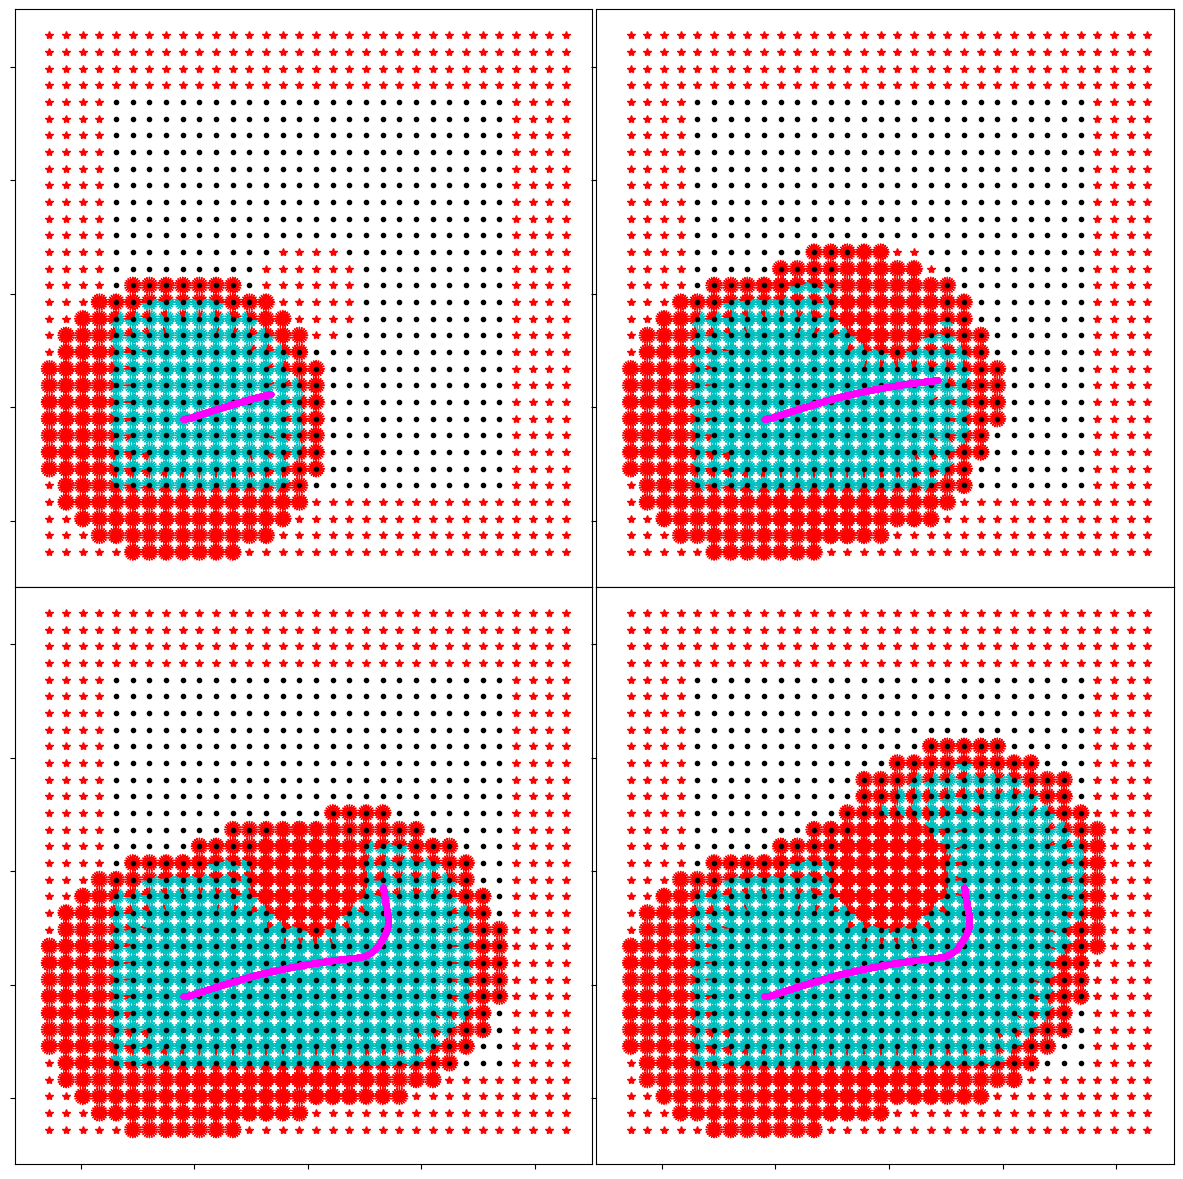

In [24]:
#######################################
### Sequential plot of learned CBFs ###
#######################################

fig = plt.figure(figsize=(15, 15))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal') 
    
fig.subplots_adjust(wspace=0, hspace=0)

for i, args in enumerate(quad_plot_args):
    quad_plot(a, axs[i], args[0], args[1], args[2], args[3], args[4], grid, obs_dict)
plt.show()

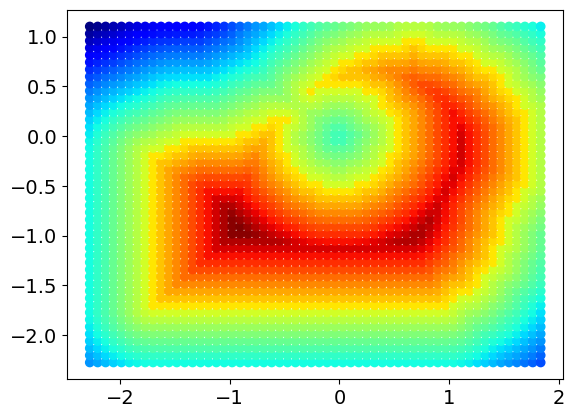

100%|###############################| 500.0000/500.0 [00:09<00:00, 53.99sim_s/s]


number of gridpoints: (167040,)
counts [18 15 14 ... 21 20 20]
pct 0.0
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 28 06:44:30 PM: Your problem has 5591 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 28 06:44:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 06:44:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 06:44:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 06:44:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------

<Figure size 640x480 with 0 Axes>

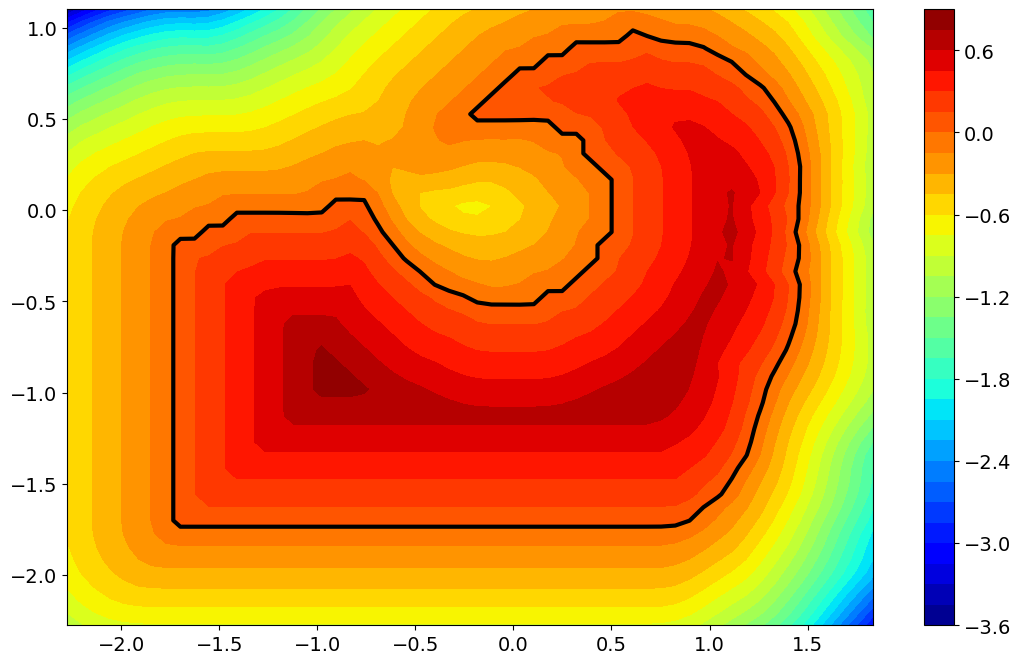

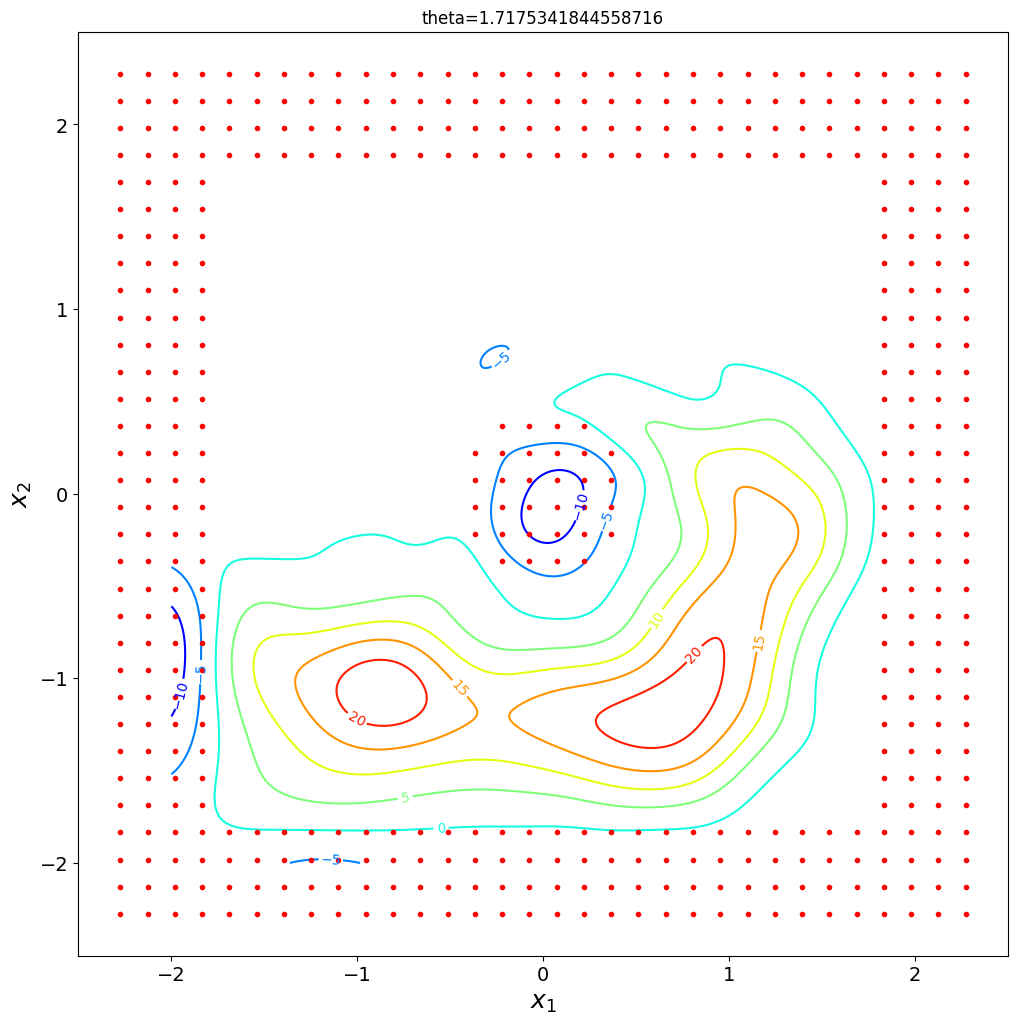

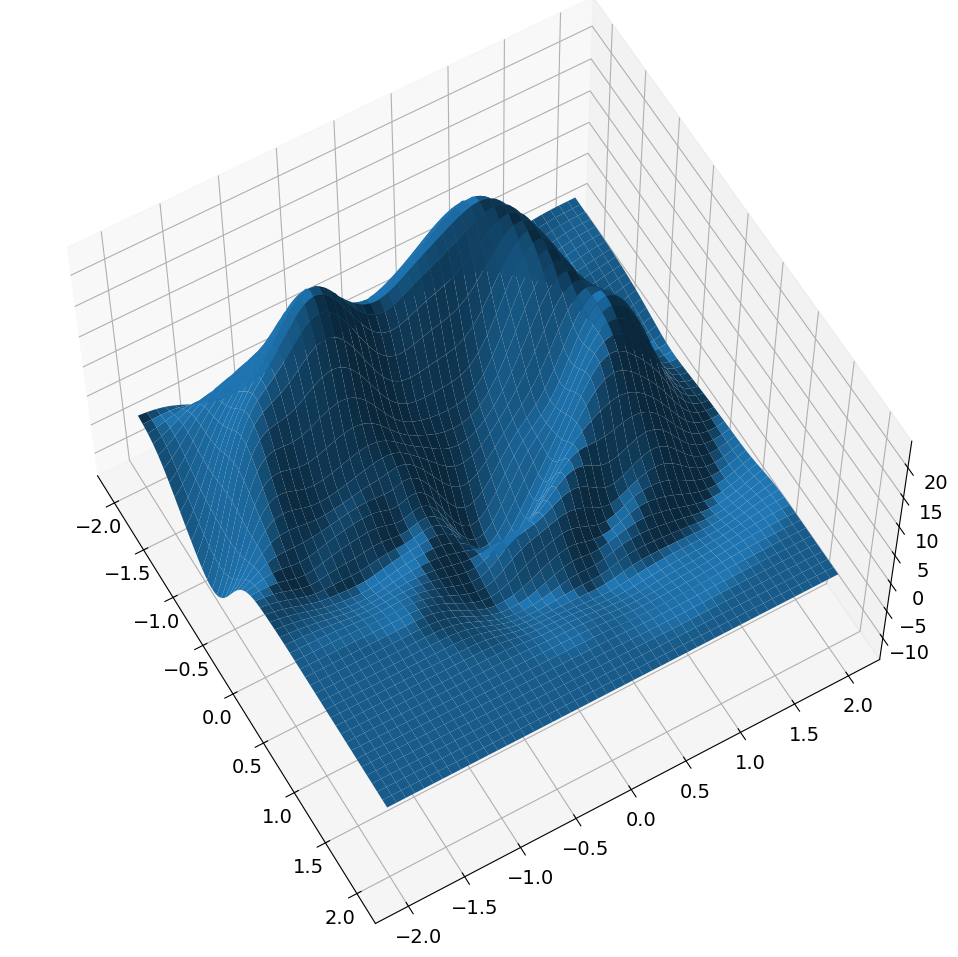

max h 23.588550297476857


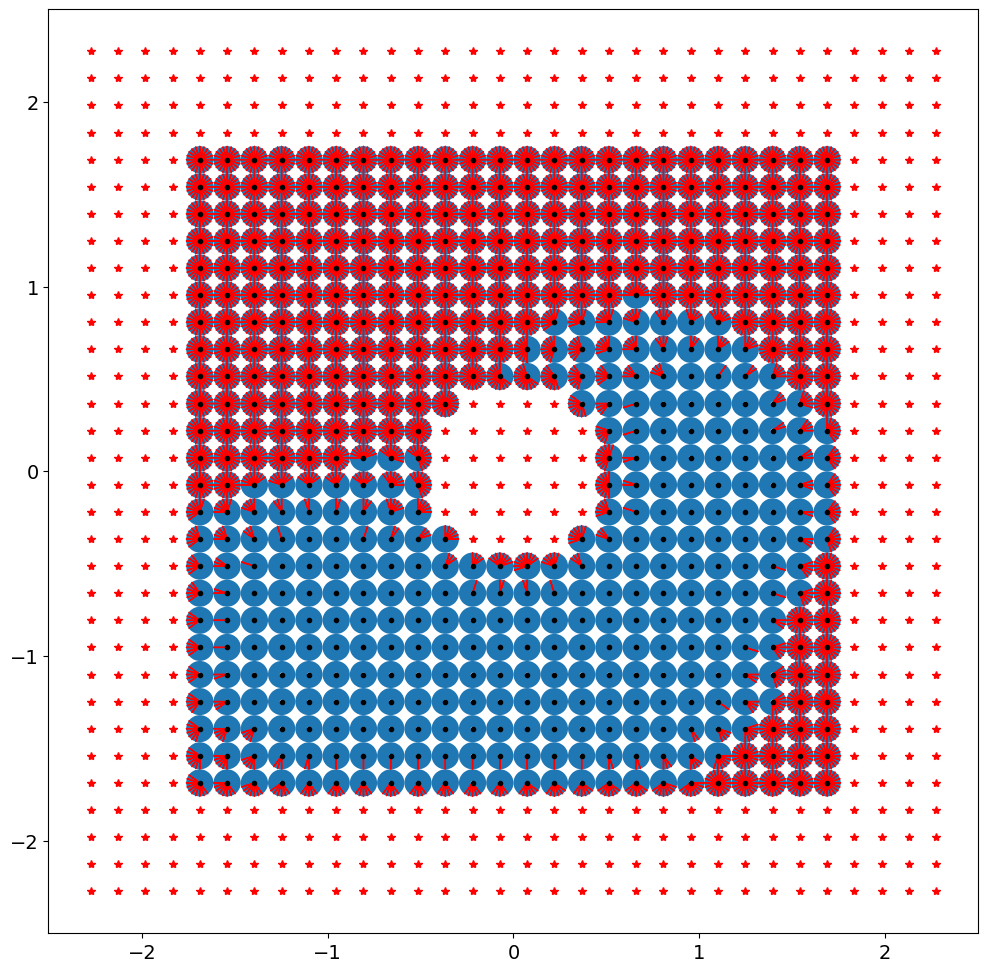

In [25]:
##################################################
### Learn a single CBF from all data collected ###
##################################################

n_safe = len(pts_safe)
all_obs_func = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
gparams = get_gparams(np.vstack((data_safe, data_unsafe)), hjb_grid)
loc_V, loc_hjb_grid = a.get_local_V(gparams, all_obs_func, thn, rx=None, out_func=out_func, T=500, mult=mult)
print("number of gridpoints:", loc_hjb_grid.states.flatten().shape)
all_x_buffer, all_x_safe = a.make_buffer(data_safe, int(nm * n_safe), pct, bicycle=True) 
all_u_safe = hjb_controls_parallel(a, all_x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    all_u_buffer = hjb_controls_parallel(a, all_x_buffer, loc_hjb_grid, loc_V)
else:
    all_u_buffer = np.array([])
all_theta = np.array(clarabel_solve_cbf(a, all_x_safe, all_u_safe, all_x_buffer, all_u_buffer, data_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, centers=all_C))
h_max = plot_cbf(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], angle=a.pos[-1], obstacles=obstacles)
_plot_angles(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], grid, hjb_grid, obs_dict)

position is [-1.2 -1.   0. ]
start time is 60


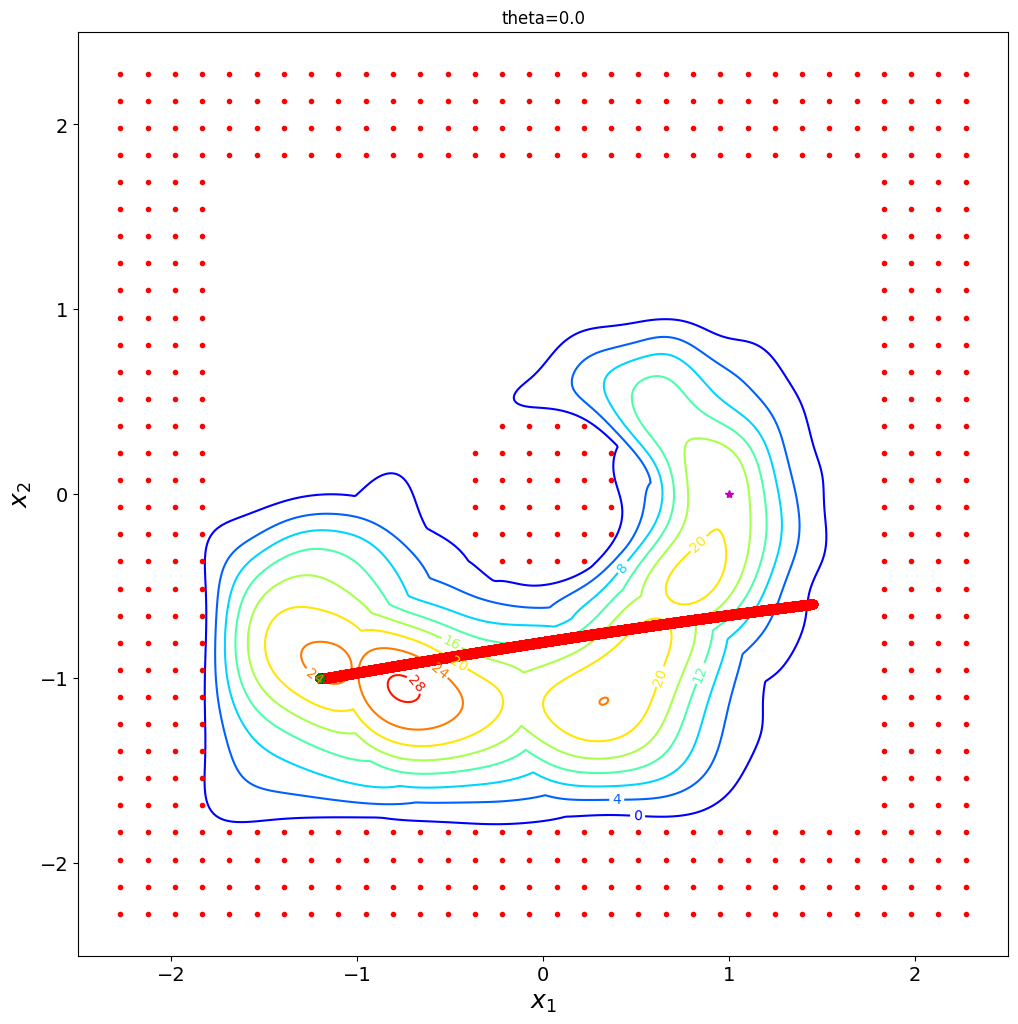

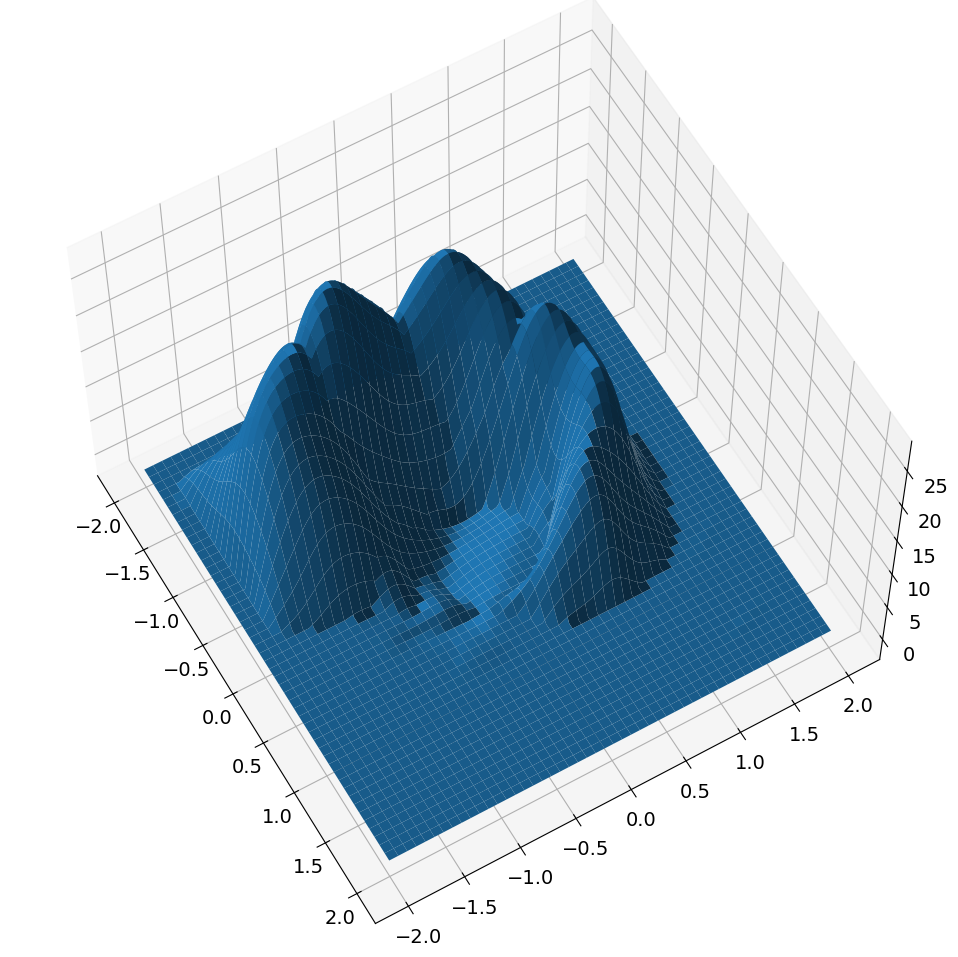

max h 28.516381907191942
new position is [ 1.45114851 -0.59735215  0.12329283]
h is now 0.04994599208816819
new time is 90
position is [-1.2 -1.   0. ]
start time is 60


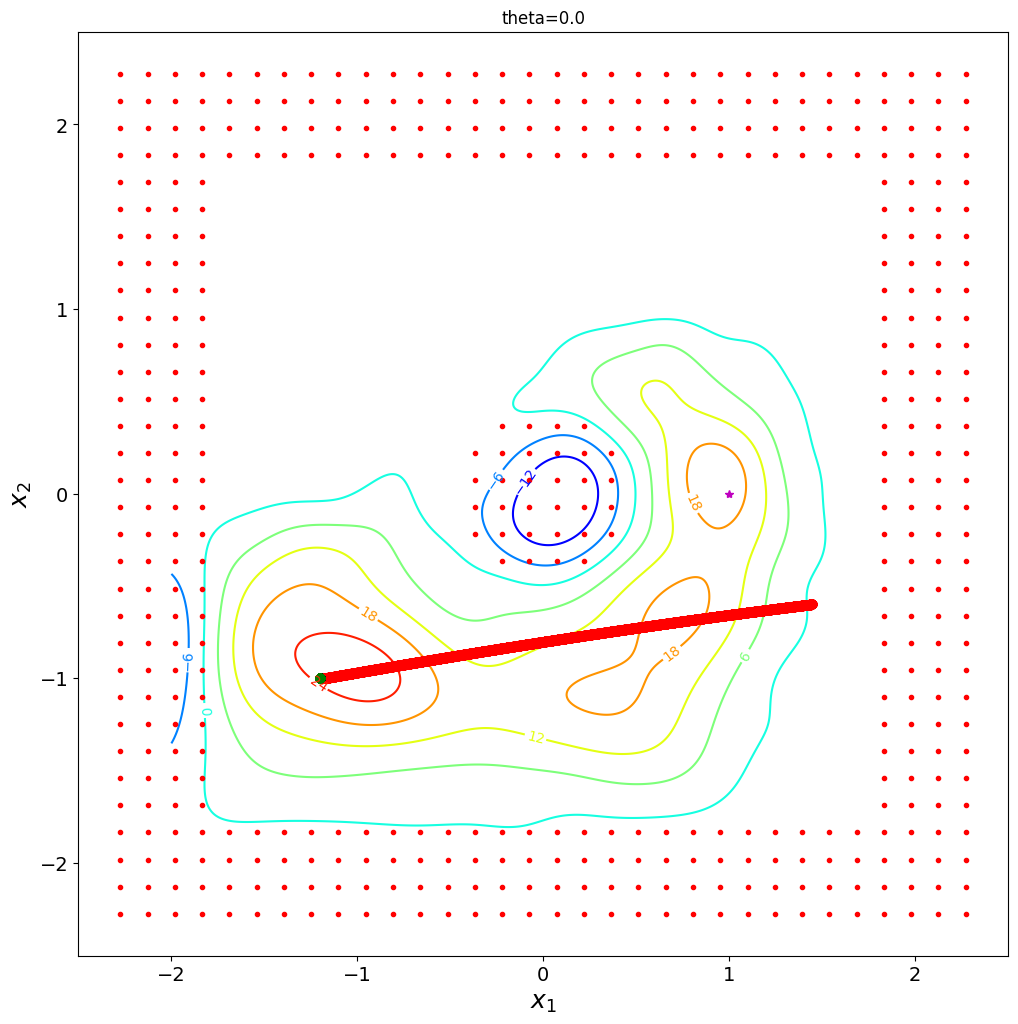

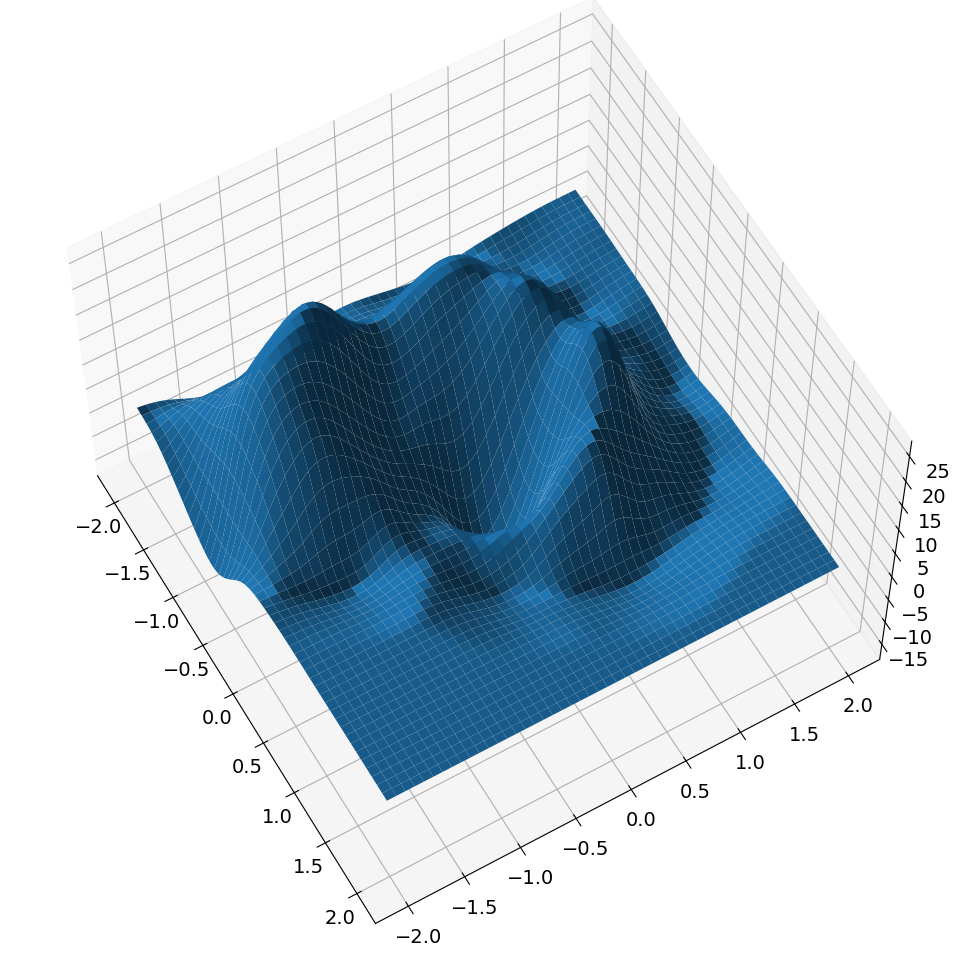

max h 27.105794184582734
new position is [ 1.44965792 -0.59854877  0.12345383]
h is now 0.04885867189563031
new time is 90


ValueError: operands could not be broadcast together with shapes (26822,2) (26822,3) 

In [26]:
#############################
### Plot velocity curves ####
#############################
import copy

a2 = copy.copy(a)
a2.thetas = [all_theta]
a2.centers= [all_C]

start_pos = np.array([-1.2 ,-1, 0])
target    = np.array([1, 0, 0])
a.pos = start_pos
a2.pos= start_pos

DT   = 0.001
mpc_DT = 0.01
T    = 0.3
tol  = 0.05
tend = 30

traj ,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, mpc_DT=mpc_DT, eps=eps, bicycle=True)  
traj2,usig2= a2.goto(target, T=T, tend=tend, tol=tol, angle=a2.pos[-1], manual=True, DT=DT, mpc_DT=mpc_DT, eps=eps, bicycle=True) 


v1 = np.linalg.norm(np.vstack((traj[1:, :-1],np.array([0,0])))  - traj, axis=1)/DT
v2 = np.linalg.norm(np.vstack((traj2[1:,:-1],np.array([0,0])))  - traj2, axis=1)/DT
plt.plot(v1[:-1], color="red", label="max of local cbfs")
plt.plot(v2[:-1], color="blue", label="baseline")
plt.ylabel("velocity")
plt.xlabel("time")
plt.legend()
plt.show()

plt.plot(usig , color="red" , label="max cbf, |u|" )
plt.plot(usig2, color="blue", label="baseline, |u|")
plt.ylabel("norm of control")
plt.xlabel("time")
plt.legend()
plt.show()

In [27]:
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a2)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

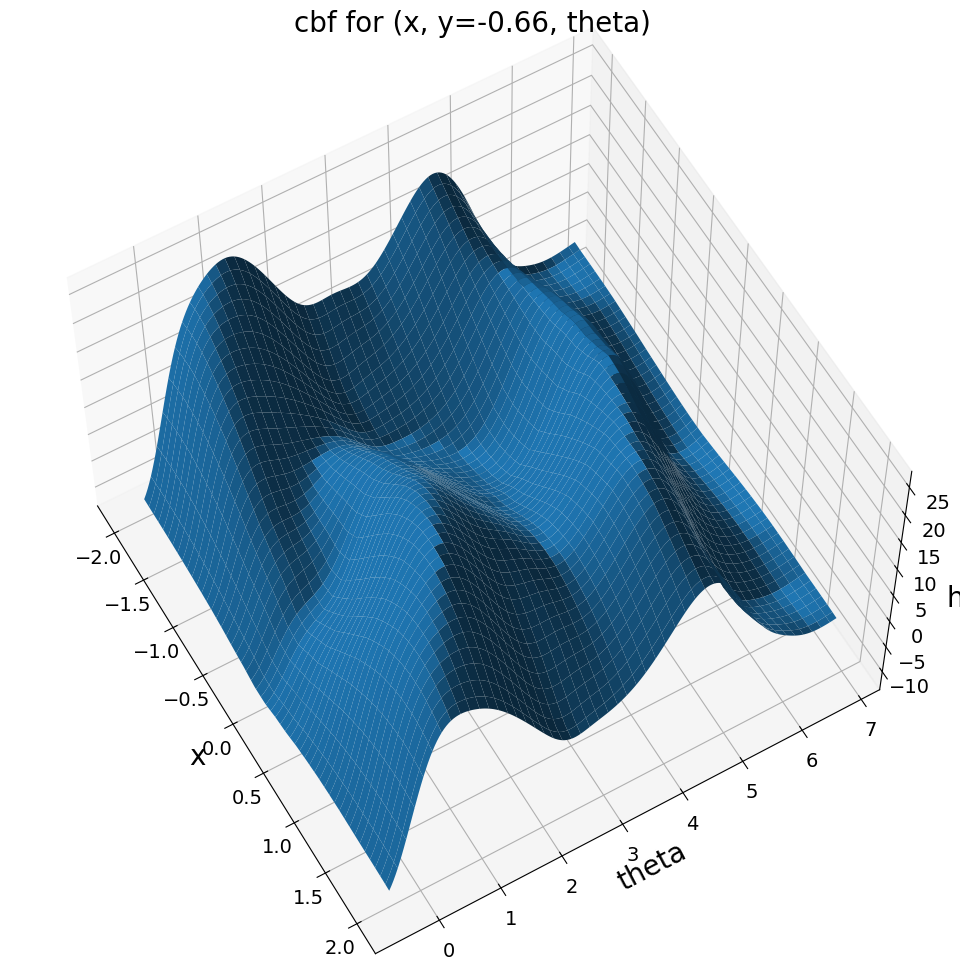

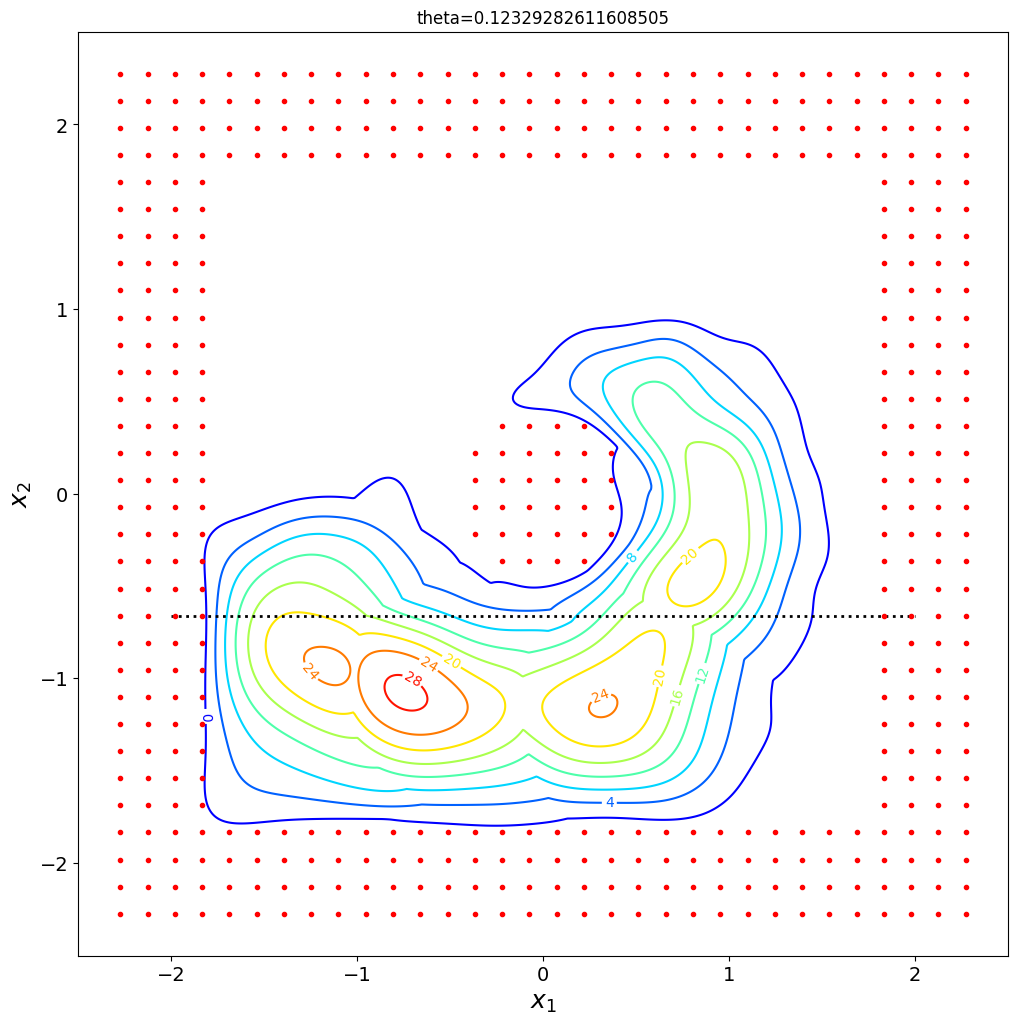

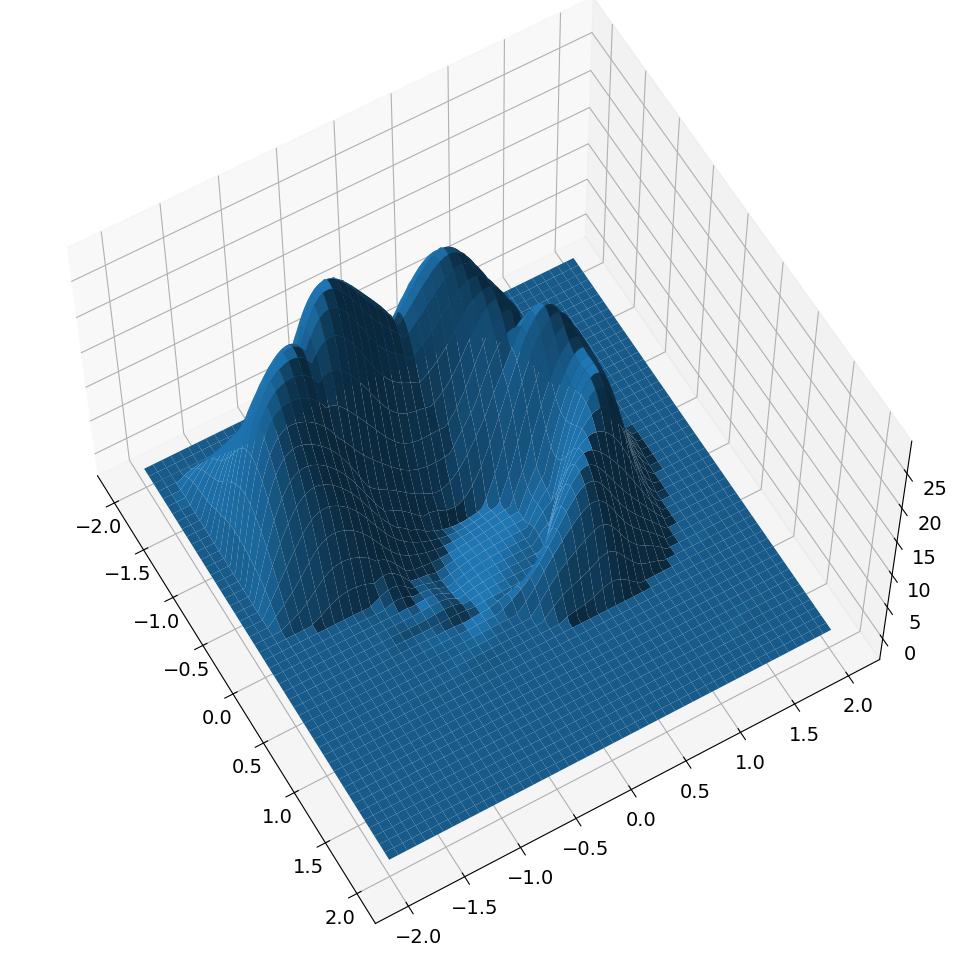

max h 28.91463672206699


In [30]:
y =-0.66
Nx = 200
Nth = 200
X = np.linspace(-2, 2, Nx)
Theta = np.linspace(0-0.5, 2*np.pi+0.5, Nth)
xx, thth = np.meshgrid(X, Theta)
h = get_h_curr(a2)
hvals = np.zeros((Nx, Nth))
for i, x in enumerate(X):
    for j, th in enumerate(Theta):
        hvals[i, j] = h(np.array([x, y, th]))[0]
fig = plt.figure(figsize=(14, 12))
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=60, azim=-30)
ax.plot_surface(xx, thth, hvals)
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("theta", fontsize=20)
ax.set_zlabel("h", fontsize=20)
ax.set_title("cbf for (x, y=" + str(np.round(y, 3)) + ", theta)", fontsize=20)
plt.show()

h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1], obstacles=obstacles, line=y)